In [1]:
%matplotlib nbagg 
import numpy as np
from scipy import signal, fftpack
from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from constantes.lectura import lee_constantes_retardados
from constantes.constantes_reactores import RA1

# Simulación de la cinética puntual

### Descripción del problema:


El problema se modela asumiendo que es posible medir las señales x(t) e y(t) y que se desea averigual el tiempo de retardo $\tau$ que existen entre llas:

\begin{align}
\frac{dn}{dt}(t) &= \frac{\rho(t) - \beta}{\Lambda} n(t) + \sum_{i=1}^6 \lambda_i C_i(t) + S(t)\\
\frac{dC_i}{dt}(t) &= \frac{\beta_i}{\Lambda} n(t) - \lambda_i C_i(t) \quad i=1...6
\end{align}

en donde:

$n(t)$ : densidad neutrónica

$C_i(t)$ : concentración de precursores de neutrones retardados del grupo i-ésimo

$\beta$ : fracción *efectiva* de neutrones retardados

$\beta_i$ : fracción *efectiva* de neutrones retardados del grupo i-ésimo

$\Lambda$ : Tiempo entre reproducciones

$\rho(t)$ : reactividad

$S(t)$ : fuente de neutrones externa

Usualmente, al utilizar la cinética puntual para la estimación de parámetros en un reactor, se suele trabajar con magnitudes reducidas. Esto se logra definiendo:

$\$(t) = \frac{\rho(t)}{\beta}$ : reactividad expresada en dólares

$b_i = \frac{\beta_i}{\beta}$ : fracción reducida de neutrones retardados del grupo i-ésimo

$\Lambda^* = \frac{\Lambda}{\beta}$ : Tiempo entre reproducciones reducido

Con estas definiciones, las ecuaciones quedan:

\begin{align}
\frac{dn}{dt}(t) &= \frac{\$(t) - 1}{\Lambda^*} n(t) + \sum_{i=1}^6 \lambda_i C_i(t) + S(t)\\
\frac{dC_i}{dt}(t) &= \frac{b_i}{\Lambda^*} n(t) - \lambda_i C_i(t) \quad i=1...6
\end{align}

La ventaja de utilizar estas variables son:

a) $\Lambda^*$ se puede estimar de forma directa a través de mediciones en un reactor nuclear
    
b) El valor $b_i$ se lo puede considerar independiente del tipo de reactor, pues se considera que $b_i = \frac{\beta_i}{\beta} \approx \frac{\gamma \beta_i^{nuclear}}{\gamma\beta^{nuclear}} = \frac{\beta_i^{nuclear}}{\beta^{nuclear}}$

## Resolución numérica de la cinética puntual

Para resolver las ecuacioes numéricamente, conviene trabajar con notacion matricial:

A las variables que deseamos calcular las agrupamos en un vector:

\begin{equation}
    X(t) = \begin{bmatrix} n(t) \\ C_1(t) \\ \vdots \\ C_6(t) \end{bmatrix}
\end{equation}

Y definimos la matríz con los coeficientes del sistema:

\begin{equation}
   A(t) = \begin{bmatrix}
                           \frac{1-\$(t)}{\Lambda^*} & \lambda_1 & \cdots & \lambda_6 \\
                           \frac{b_1}{\Lambda^*} & -\lambda_1 & 0  & 0 \\
                           \vdots & 0  & \ddots & 0 \\
                           \frac{b_6}{\Lambda^*} & 0 & 0 & -\lambda_6 \\
          \end{bmatrix}
\end{equation}

y finalmente el término inhomogéneo:

\begin{equation}
    B(t) = \begin{bmatrix} S(t) \\ 0 \\ \vdots \\ 0 \end{bmatrix}
\end{equation}

con estas definiciones, ahora se puede escribir al sistema como:

\begin{equation}
\frac{dX}{dt}(t) = A(t)X(t) + B(t)
\end{equation}

** Se construye la matríz A: **

In [2]:
# Se leen juego de cosntantes nucleares de neutrones retardados
b, lam , beta = lee_constantes_retardados('Tuttle')

In [3]:
# Se leen constantes características de cada reactor
Lambda_red = RA1.LAMBDA_REDUCIDO
Lambda_red

0.0119

In [4]:
A = np.zeros((7,7))
A[1:, 1:] = np.diag(-lam)
A[0, 1: ] = lam
A[1:, 0] = b / Lambda_red
np.set_printoptions(precision=2, suppress=True)
print('A = \n', A)
np.set_printoptions(precision=8, suppress=False)

A = 
 [[  0.     0.01   0.03   0.12   0.31   1.4    3.87]
 [  3.19  -0.01   0.     0.     0.     0.     0.  ]
 [ 17.9    0.    -0.03   0.     0.     0.     0.  ]
 [ 15.8    0.     0.    -0.12   0.     0.     0.  ]
 [ 34.2    0.     0.     0.    -0.31   0.     0.  ]
 [ 10.76   0.     0.     0.     0.    -1.4    0.  ]
 [  2.18   0.     0.     0.     0.     0.    -3.87]]


Se definen los valores de reactividad y de fuente para toda la simulación:

In [5]:
def rho(t):
    if t>= 10:
        return -4.0
    elif t>= 2:
        return -4.0
    elif t<= 2:
        return  -5.0

def S(t):
    _vect = np.zeros(7)
    if  t>=15:
        _vect[0]=  1e5
    elif t<= 15:
        _vect[0] = 1e5
    return _vect

Se define la función que se va a integrar:

In [6]:
# Si utilizo scipy.integrate.odeint:
def func(X, t, P, U):
    P[0, 0] = (rho(t)-1) / Lambda_red
    return np.matmul(P, X) + U(t)

# Si utilizo scipy.integrate.ode
# (Cambia el órden de los parámetros t y X)
def func_ode(t, X, P, U):
    P[0, 0] = (rho(t)-1) / Lambda_red
    return np.asarray(np.matmul(P, X) + U(t))

Se definen las condiciones iniciales del problema.
Se asume que en cualquier caso siempre se tendrá un reactor estacionario.

In [7]:
if S(0)[0] == 0.0:
    if rho(0) != 0:
        raise Exception('El reactor no se encuentra inicialmente estacionario (S=0 y rho!=0)')
    else:
        n0 = 1
else:
    if rho(0) >= 0:
        raise Exception('El reactor no se encuentra inicialmente estacionario (S!=0 y rho>=0)')
    else:
        n0 = - Lambda_red * S(0)[0] / rho(0)

X0 = b / lam / Lambda_red * n0
X0 = np.insert(X0, 0, n0)

Se definen el vector temporal para la simulación:

In [8]:
# Tiempo máximo de la integración
tmax = 30
# Cantidad de puntos
Npunt = 30000
# Vector temporal (para odeint)
t = np.linspace(0.0, tmax, Npunt)
# Paso de integración (para ode)
dt = t[1]-t[0]
print('Paso de integración utilizado : {}'.format(dt))

Paso de integración utilizado : 0.0010000333344444814


Se resuelven las ecuaciones.

In [9]:
# ------ Se resuelve utilizando scipy.integrate.odeint
y = odeint(func, X0, t, (A, S))


# ------ Se resuelve utilizando scipy.integrate.ode
r = ode(func_ode)
r.set_integrator('dopri5', max_step=dt)
r.set_initial_value(X0, 0.0)
r.set_f_params(A, S)

t_ode = []
y_ode = []
while r.successful() and r.t < tmax:
    t_ode.append(r.t)
    y_ode.append(r.y)
    r.integrate(r.t+dt) 

t_ode = np.asarray(t_ode)
y_ode = np.asarray(y_ode)

<IPython.core.display.Javascript object>


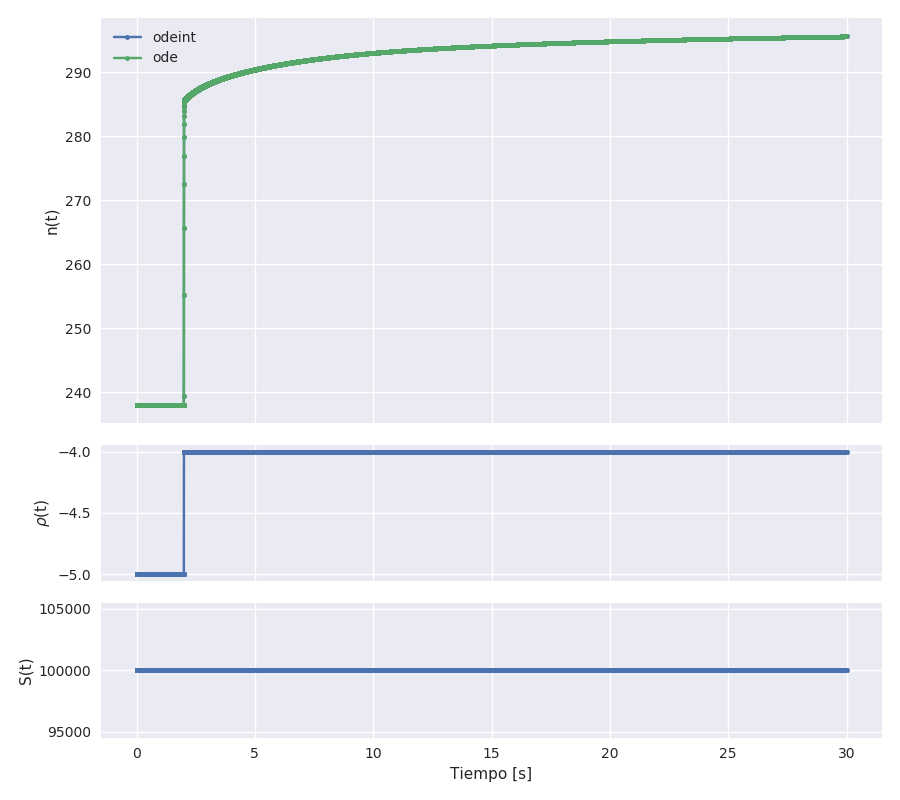

In [10]:
# Graficación

fig, ax = plt.subplots(3, 1, figsize=(9,8), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)
ax[0].plot(t, y[:,0], '.-', label='odeint') 
ax[0].plot(t_ode, y_ode[:,0], '.-', label='ode') 
ax[0].set_yscale('linear')
ax[0].set_ylabel('n(t)')
ax[0].legend()

reactividad = np.asarray(list(map(rho,t)))
ax[1].plot(t, reactividad, '.-')
ax[1].set_ylabel(r'$\rho$(t)')

fuente = np.asarray(list(map(S,t)))[:, 0]
ax[2].plot(t, fuente, '.-')
ax[2].set_xlabel('Tiempo [s]')
ax[2].set_ylabel('S(t)')

fig.tight_layout()

### Referencias

#### 1) Funciones más relevantes utilizadas

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.odeint.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html